<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/END_NoCoDeR_FinalSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Mar 21 16:29:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import pandas as pd
import numpy as np
import fileinput
import re
import itertools
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
#import seaborn as sns
import dateutil.parser
import datetime
#from ipyfilechooser import FileChooser
import numpy as np
import os
import gzip
import dateutil.parser
from datetime import datetime
import sys
import glob
import matplotlib.dates as mdates
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display
import torch
import json
import random
import spacy
from pprint import pprint
import six
import sys, token, tokenize
import ast
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
import math
import time
from torch.utils.data.distributed import DistributedSampler
#from tensorboardX import SummaryWriter
from tqdm import tqdm, trange
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install transformers
!pip install rouge-score

In [5]:
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import tokenize

In [6]:
!cp /content/drive/MyDrive/EVA4/END_Capstone/english_python_data.txt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/english_python_cleaned.txt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone.csv .

In [7]:
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from transformers import AutoTokenizer, AutoModel


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
auto_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
# spacy_en = spacy.load('en')
# def tokenize_en(text):
#     """
#     Tokenizes English text from a string into a list of strings
#     """
#     return [tok.text for tok in spacy_en.tokenizer(text)]
# #model = RobertaModel.from_pretrained("microsoft/codebert-base")
# #model.to(device)

#### Function to remove docstrings and comments

In [8]:
"""
    Removes docstrings and comments
"""
def remove_docstrings_comments(src_string, doc_string=None, debug=False):
    mod = []

    prev_toktype = token.INDENT
    first_line = None
    last_lineno = -1
    last_col = 0
    try:
        #tokgen = tokenize.generate_tokens(source.readline)
        tokgen = tokenize.generate_tokens(six.StringIO(src_string.rstrip()).readline)
        for toktype, ttext, (slineno, scol), (elineno, ecol), ltext in tokgen:
            if 0:   # Change to if 1 to see the tokens fly by.
                print("%10s %-14s %-20r %r" % (
                    tokenize.tok_name.get(toktype, toktype),
                    "%d.%d-%d.%d" % (slineno, scol, elineno, ecol),
                    ttext, ltext
                    ))
            if slineno > last_lineno:
                last_col = 0
            if scol > last_col:
                mod.append(" " * (scol - last_col))
            if toktype == token.STRING and prev_toktype == token.INDENT:
                # Docstring
                mod.append("#--")
            elif toktype == tokenize.COMMENT:
                # Comment
                mod.append("##")
            else:
                mod.append(ttext)
            prev_toktype = toktype
            last_col = ecol
            last_lineno = elineno
        return "".join(mod)
    except:
        print(doc_string)
        print(src_string )
        print(sys.exc_info())

We load the data from CSV file which contains the docstring, code, docstring_len, code_len, cleaned_code and cleaned_code_len

In [9]:
nl_to_pl_df = pd.read_csv('/content/end_capstone.csv')

In [10]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [11]:
print(nl_to_pl_df['code_len'].max(),nl_to_pl_df['code_len'].min())
print(nl_to_pl_df['docstring_len'].max(),nl_to_pl_df['docstring_len'].min())
nl_to_pl_df[nl_to_pl_df['code_len'] ==0]
nl_to_pl_df[(nl_to_pl_df['code_len'] > 256) & (nl_to_pl_df['code_len'] < 512)] 

2443 11
313 16


,docstring,code,docstring_len,code_len,cleaned_code,cleaned_code_len
5,# Write a program to check whether a number is...,num = 337\n\nif num > 1:\n for i in range(2...,60,311,num = 337\n\nif num > 1:\n for i in range(2...,308
7,# Write a program to find the factorial of a n...,num = 13\nfactorial = 1\n\nif num < 0:\n pr...,52,265,num = 13\nfactorial = 1\n\nif num < 0:\n pr...,262
53,# Write a function that takes in height(m) and...,"\ndef bmi(height: ""Meters"", weight: ""Kgs""):\n ...",98,450,"\ndef bmi(height: ""Meters"", weight: ""Kgs""):\n ...",447
62,# write a python program to sort dictionary it...,"dict1 = {'car': [7, 6, 3], \n 'bike': ...",50,262,"dict1 = {'car': [7, 6, 3], \n 'bike': ...",260
74,# write a python program to Get the maximum an...,"\nmy_dict = {'x':500, 'y':5874, 'z': 560}\n\nk...",78,276,"\nmy_dict = {'x':500, 'y':5874, 'z': 560}\n\nk...",274
...,...,...,...,...,...,...
4352,# Define a class named Shape and its subclass ...,\n\nclass Shape(object):\n def __init__(sel...,234,314,\n\nclass Shape(object):\n def __init__(sel...,312
4354,# Write a python program for a binary search f...,"import math\ndef bin_search(li, element):\n ...",171,390,"import math\ndef bin_search(li, element):\n ...",388
4359,# Write a python program to check if a number ...,"n = int(input(""Enter any number: ""))\nsum1 = 0...",67,261,"n = int(input(""Enter any number: ""))\nsum1 = 0...",259
4360,# Write a python program to Check if a Number ...,"sum1 = 0\nnum = int(input(""Enter a number:""))\...",65,347,"sum1 = 0\nnum = int(input(""Enter a number:""))\...",345


In [12]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    # if n_gpu > 0:
    #     torch.cuda.manual_seed_all(seed)
set_seed(0x1112233)

In [ ]:
!cp -rf /content/drive/MyDrive/EVA4/END_Capstone/cubert .
!pip install -r /content/cubert/requirements.txt
sys.path.append("/content/cubert/")

### CuBert Tokenizer

PythonTokenizer2 is a subclass of [CuBertTokenizer](https://github.com/google-research/google-research/tree/master/cubert). It is capable of tokenizing both Python2.x and Python3.x snippets.

It implements two basic methods:


*   tokenize_and_abstract: Converts a code snippet to relevant tokens with special tokens marked accordingly
*   untokenize_abstract: Useful for forming actual code from an array/list of tokens. Throws Exception if there are no proper EOS/ENDMARKER.




In [15]:
"""A Python tokenizer subclass of CuBertTokenizer."""
import keyword
import re
import tokenize
import typing
from typing import Any
from typing import List
from typing import Sequence
from typing import Tuple
from absl import logging
from cubert import cubert_tokenizer
from cubert import unified_tokenizer


class PythonTokenizer2(cubert_tokenizer.CuBertTokenizer):
  """Tokenizer that extracts Python's lexical elements preserving strings."""
  _TOKEN_TYPE_MAP = {
      tokenize.COMMENT: unified_tokenizer.TokenKind.COMMENT,
      tokenize.DEDENT: unified_tokenizer.TokenKind.KEYWORD,
      tokenize.ENDMARKER: unified_tokenizer.TokenKind.EOS,
      tokenize.ERRORTOKEN: unified_tokenizer.TokenKind.ERROR,
      tokenize.INDENT: unified_tokenizer.TokenKind.KEYWORD,
      tokenize.NEWLINE: unified_tokenizer.TokenKind.NEWLINE,
      tokenize.NL: unified_tokenizer.TokenKind.PUNCTUATION,
      tokenize.NUMBER: unified_tokenizer.TokenKind.NUMBER,
      tokenize.OP: unified_tokenizer.TokenKind.PUNCTUATION,
      tokenize.STRING: unified_tokenizer.TokenKind.STRING,
  }
  _REVERSE_TOKEN_MAP = {
      cubert_tokenizer.token_from_token_type(tokenize.INDENT):
          tokenize.INDENT,
      cubert_tokenizer.token_from_token_type(tokenize.DEDENT):
          tokenize.DEDENT,
      unified_tokenizer.quote_special(unified_tokenizer.TokenKind.EOS.name):
          tokenize.ENDMARKER,
      unified_tokenizer.quote_special(unified_tokenizer.TokenKind.ERROR.name):
          tokenize.ERRORTOKEN,
      unified_tokenizer.quote_special(unified_tokenizer.TokenKind.NEWLINE.name):
          tokenize.NEWLINE,
      cubert_tokenizer.token_from_token_type(tokenize.NL):
          tokenize.NL,
  }
  # Adding the end-of-string anchor \Z below, since re.fullmatch wasn't
  # available in Python2.
  _NUMBERS = re.compile('(' + tokenize.Number + r')\Z')  # pytype: disable=module-attr
  _SINGLE_STRINGS = re.compile('(' + tokenize.String + r')\Z')  # pytype: disable=module-attr
  _TRIPLE_STRING_BEGINNINGS = re.compile(tokenize.Triple)  # pytype: disable=module-attr
  _COMMENTS = re.compile('(' + tokenize.Comment + r')\Z')  # pytype: disable=module-attr

  _EXACT_TOKEN_TYPES = tokenize.EXACT_TOKEN_TYPES.keys()  # pytype: disable=module-attr

  # Token types that CubertTokenizer will tokenize by their type and not
  # content.
  _TOKEN_TYPES_TO_TOKENIZE_BY_TYPE = [
      tokenize.NEWLINE, tokenize.DEDENT, tokenize.NL
  ]

  def tokenize_and_abstract(
      self,
      source_code):
    """Produces a language-agnostic tokenization of the input code."""
    agnostic_tokens: List[unified_tokenizer.AbstractToken] = []

    try:
      token_tuples = unified_tokenizer.code_to_tokens(source_code)
    except (tokenize.TokenError, IndentationError) as e:
      logging.warning('The tokenizer raised exception `%s` while parsing %s', e,
                      source_code)

      # We don't try to do recovery from errors quite yet. Emit just an
      # error and end-of-sequence and return.
      agnostic_tokens.append(
          unified_tokenizer.AbstractToken(
              unified_tokenizer.quote_special(
                  unified_tokenizer.TokenKind.ERROR.name),
              unified_tokenizer.TokenKind.ERROR,
              unified_tokenizer.TokenMetadata(
                  start=unified_tokenizer.Position(
                      line=0, column=0),
                  end=unified_tokenizer.Position(
                      line=0, column=0))))
      agnostic_tokens.append(
          unified_tokenizer.AbstractToken(
              unified_tokenizer.quote_special(
                  unified_tokenizer.TokenKind.EOS.name),
              unified_tokenizer.TokenKind.EOS,
              unified_tokenizer.TokenMetadata(
                  start=unified_tokenizer.Position(
                      line=0, column=0),
                  end=unified_tokenizer.Position(
                      line=0, column=0))))
      return agnostic_tokens

    for token_tuple in token_tuples:
      spelling = token_tuple.string
      kind = token_tuple.type

      # We'll adjust the spelling of some tokens, e.g., those that we
      # tokenize by their type rather than their original spelling. Indentation
      # and dedentation tokens are like that.
      adjusted_spelling = spelling
      token_kind = unified_tokenizer.TokenKind.NONE
      if kind == tokenize.NAME:
        # Disambiguate identifiers from keywords.
        if keyword.iskeyword(spelling):
          token_kind = unified_tokenizer.TokenKind.KEYWORD
        else:
          token_kind = unified_tokenizer.TokenKind.IDENTIFIER
      else:
        if kind in PythonTokenizer2._TOKEN_TYPES_TO_TOKENIZE_BY_TYPE:
          # Replace spelling with type.
          adjusted_spelling = cubert_tokenizer.token_from_token_type(kind)
        elif kind is tokenize.INDENT:
          # For INDENT, in particular, we also record the actual spelling too.
          adjusted_spelling = '{indent}{spelling}'.format(
              indent=cubert_tokenizer.token_from_token_type(kind),
              spelling=spelling)
          #print(adjusted_spelling)
        elif kind == tokenize.ENDMARKER:
          adjusted_spelling = unified_tokenizer.quote_special(
              unified_tokenizer.TokenKind.EOS.name)

        # Map everything according to table.
        try:
          token_kind = PythonTokenizer2._TOKEN_TYPE_MAP[kind]
        except KeyError as ke:
          # It's possible we're here because of async/await. Those kept being
          # turned into keywords and then removed from keywords, so we can't
          # rely on knowing which they are. We'll check by spelling.
          # See: https://bugs.python.org/issue30406
          # and https://bugs.python.org/issue33260
          # and https://bugs.python.org/issue35975
          if spelling in ('async', 'await'):
            token_kind = unified_tokenizer.TokenKind.KEYWORD
          else:
            raise ValueError('While trying to turn Python token %r into an '
                             'agnostic one, raised %r.' %
                             ((spelling, kind), ke))

      start_line, start_column = token_tuple.start
      end_line, end_column = token_tuple.end
      # Unlike other languages, NEWLINE tokens are reported as ending on the
      # same line as where they started. We adjust that here, to stick to the
      # same convention as other tokenizers.
      if ((token_kind == unified_tokenizer.TokenKind.NEWLINE) or
          (kind == tokenize.NL)):
        end_line = start_line + 1
        end_column = 0

      agnostic_tokens.append(
          unified_tokenizer.AbstractToken(
              spelling=adjusted_spelling, kind=token_kind,
              metadata=unified_tokenizer.TokenMetadata(
                  # Python's tokenizer counts lines starting from 1, so we
                  # have to offset what we read from the `TokenInfo` tuple.
                  start=unified_tokenizer.Position(
                      line=start_line - 1, column=start_column),
                  end=unified_tokenizer.Position(
                      line=end_line - 1, column=end_column))))
    #print(agnostic_tokens)
    return agnostic_tokens

  def untokenize_abstract(self, whole_tokens):
    # Reconstruct Python tokenizer tuples, so that Python's untokenize can be
    # invoked.
    token_tuples: List[Tuple[int, str]] = []

    for whole_token in whole_tokens:
      if whole_token in PythonTokenizer2._EXACT_TOKEN_TYPES:
        token_tuples.append((tokenize.OP, whole_token))
      elif cubert_tokenizer.token_from_token_type(
          tokenize.INDENT) in whole_token:
        # We baked the type and spelling into one token. Break them up.
        spelling = whole_token.replace(
            cubert_tokenizer.token_from_token_type(tokenize.INDENT), '')
        token_tuples.append((tokenize.INDENT, spelling))
      elif whole_token in PythonTokenizer2._REVERSE_TOKEN_MAP:
        python_kind = PythonTokenizer2._REVERSE_TOKEN_MAP[whole_token]
        if python_kind in (tokenize.DEDENT, tokenize.ENDMARKER,
                           tokenize.ERRORTOKEN):
          spelling = ''
        else:  # python_kind in (tokenize.NEWLINE, tokenize.NL)
          spelling = '\n'
        token_tuples.append((python_kind, spelling))
      elif keyword.iskeyword(whole_token):
        token_tuples.append((tokenize.NAME, whole_token))
      elif PythonTokenizer2._NUMBERS.match(whole_token):
        token_tuples.append((tokenize.NUMBER, whole_token))
      elif PythonTokenizer2._SINGLE_STRINGS.match(whole_token):
        token_tuples.append((tokenize.STRING, whole_token))
      elif PythonTokenizer2._TRIPLE_STRING_BEGINNINGS.match(whole_token):
        token_tuples.append((tokenize.STRING, whole_token))
      elif PythonTokenizer2._COMMENTS.match(whole_token):
        token_tuples.append((tokenize.COMMENT, whole_token))
      else:
        # Everything else we map back to NAME.
        token_tuples.append((tokenize.NAME, whole_token))

    reconstructed = tokenize.untokenize(typing.cast(Any, token_tuples))
    return reconstructed



Below function will extract both tokens and the token types from the code. With original CuBert tokenizer, every camel-cased variable name was split into multiple tokens (E.g: named_func = [named_^, ^func]) however the token type returned was just one leading to mismatch between lengths. As a workaround we copy the token type for each split of the variable name and make the lengths of token array and token_type array consistent

In [16]:
def get_lang_specific_tokens(init_tokenizer, code_snip):
    #tokens_complete = init_tokenizer.tokenize(source_code=code_snip)
    tokens = init_tokenizer.tokenize_and_abstract(source_code=code_snip )
    conditioned = init_tokenizer.condition_full_tokens(tokens)
    agnostic_token_lists = unified_tokenizer._agnostic_tokens_to_lists_of_token_lists(conditioned)
    with_identifiers_heuristically_split = unified_tokenizer._subtokenize_identifiers_heuristically(
        agnostic_token_lists)
    with_string_tokens_heuristically_split = unified_tokenizer._subtokenize_strings_heuristically(
        with_identifiers_heuristically_split)
    shortened_subtokens = unified_tokenizer._shorten_subtokens(with_string_tokens_heuristically_split, 20)
    sanitization_mapping = init_tokenizer.get_mappings()
    subtoken_lists = unified_tokenizer.sanitize_subtoken_lists(shortened_subtokens,
                                            sanitization_mapping,
                                            unified_tokenizer.SENTINEL)
    #flat_toks =unified_tokenizer.flatten_subtoken_lists(subtoken_lists)
    test_spellings = []
    test_tok_types = []
    for t in subtoken_lists:
        #if(len(t.spelling) == 1):
        #print(len(t.spellings))
        test_spellings.extend(t.spellings)
        match=False
        for cubert_token in set(init_tokenizer._REVERSE_TOKEN_MAP.keys()):
            #print("Checking for:",cubert_token)
            if cubert_token in t.spellings[0]:
                #print(t.spellings)
                selected_token = tokenize.tok_name[init_tokenizer._REVERSE_TOKEN_MAP[cubert_token]]
                test_tok_types.extend([selected_token]*len(t.spellings))
                match=True          
        if match == False:
            test_tok_types.extend([t.kind.name]*len(t.spellings))
    return test_spellings, test_tok_types



The main Vectorizer class that contains the vocab and the dictionary for Code tokens and token types.

In [17]:
class NewVectorizer():
    """
        The main Vectorizer class that contains the vocab and the dictionary 
        for Code tokens and token types.
    """
    def __init__(self, code_piece, tok_type_counter):
        self.code_piece = code_piece
        self.tok_type_counter = tok_type_counter
        self.code_word2idx = {'<s>':0,'</s>':1,'<pad>':2, '<unk>':3}
        self.code_idx2word = {v:k for k,v in self.code_word2idx.items()}
        self.toktype_word2idx = {'<s>':0,'</s>':1,'<pad>':2, '<unk>':3}
        self.toktype_idx2word = {v:k for k,v in self.toktype_word2idx.items()}
        self.max_tok_length = len(self.toktype_word2idx)
        self.max_code_length = len(self.code_word2idx)
        self.UNK_FOR_TOKEN_TYPE = '<unk>'
        self.UNK_FOR_CODEPIECE = '<unk>'
        self.ID_UNK_TOKEN_TYPE = self.toktype_word2idx[self.UNK_FOR_TOKEN_TYPE]
        self.ID_UNK_CODEPIECE = self.code_word2idx[self.UNK_FOR_CODEPIECE]

        self.PAD_FOR_CODEPIECE = '<pad>'
        self.PAD_FOR_TOKEN_TYPE = '<pad>'
        self.ID_PAD_FOR_CODEPIECE = self.code_word2idx['<pad>']
        self.ID_PAD_FOR_TOKEN_TYPE = self.toktype_word2idx['<pad>']
        
        self.SOS_FOR_CODEPIECE = '<s>'
        self.SOS_FOR_TOKEN_TYPE = '<s>'
        self.ID_SOS_FOR_CODEPIECE = self.code_word2idx['<s>']
        self.ID_SOS_FOR_TOKEN_TYPE = self.toktype_word2idx['<s>']

        self.EOS_FOR_CODEPIECE = '</s>'
        self.EOS_FOR_TOKEN_TYPE = '</s>'
        self.ID_EOS_FOR_CODEPIECE = self.code_word2idx['</s>']
        self.ID_EOS_FOR_TOKEN_TYPE = self.toktype_word2idx['</s>']
        self.build_vocab()

    def build_vocab(self):
        idx=len(self.code_word2idx.keys())
        for k in self.code_piece.keys():
            self.code_word2idx[k]=idx
            self.code_idx2word[idx]=k
            idx += 1
        
        idx=len(self.toktype_word2idx.keys())
        for k in self.tok_type_counter.keys():
            self.toktype_word2idx[k]=idx
            self.toktype_idx2word[idx]=k
            idx += 1

        self.max_tok_length = len(self.toktype_word2idx.keys())
        self.max_code_length = len(self.code_word2idx.keys())
    ### Returns the code piece for a given ID
    def convert_id_to_codepiece(self, id_for_code):
        if(id_for_code not in list(self.code_idx2word.keys())):
            return self.UNK_FOR_CODEPIECE
        return self.code_idx2word[id_for_code]
    ### Returns the ID for a given code piece
    def convert_codepiece_to_id(self, code_piece):
        if(code_piece not in list(self.code_word2idx.keys())):
            return self.ID_UNK_CODEPIECE
        return self.code_word2idx[code_piece]
    ### Returns the TOKEN ID for a given TOKEN type
    def convert_toktype_to_id(self, tok_piece):
        if(tok_piece not in list(self.toktype_word2idx.keys())):
            print("No match for",tok_piece)
            return self.ID_UNK_TOKEN_TYPE
        return self.toktype_word2idx[tok_piece]
    ### Returns the TOKEN type for a given TOKEN ID
    def convert_id_to_toktype(self, id_for_toktype):
        if(id_for_toktype not in list(self.toktype_idx2word.keys())):
            return self.UNK_FOR_TOKEN_TYPE
        return self.toktype_idx2word[id_for_toktype]

In [18]:
sys.path.append("/content/cubert")

In [19]:
import cubert
from absl import app
from absl import flags
from tensor2tensor.data_generators import text_encoder
import enum
import cubert_tokenizer
from cubert import code_to_subtokenized_sentences
#from cubert import tokenizer_registry
from cubert import python_tokenizer
import python_tokenizer
from tensor2tensor.data_generators import text_encoder_build_subword
from collections import Counter, defaultdict

@enum.unique
class TokenizerEnum(enum.Enum):
  """Enum for Tokenizers."""
  #PYTHON = python_tokenizer.PythonTokenizer
  PYTHON = PythonTokenizer2

In [20]:
#### Generate and create the Vectorizer instance
word_counter=Counter()
init_tokenizer=PythonTokenizer2()
tok_type_counter = Counter()
for code_snip in nl_to_pl_df['cleaned_code']:
    toks, tok_types = get_lang_specific_tokens(init_tokenizer, code_snip)
    word_counter.update(Counter(toks))
    tok_type_counter.update(Counter(tok_types))

In [21]:
code_tok_vectorizer = NewVectorizer(word_counter, tok_type_counter)
print(code_tok_vectorizer.max_code_length,code_tok_vectorizer.max_tok_length)

5813 16


In [ ]:
nl_to_pl_df['docstring_len'].quantile([.5, .7, .8, .9, .95])

0.50     71.0
0.70     85.0
0.80     96.0
0.90    115.0
0.95    134.0
Name: docstring_len, dtype: float64

### Dataset generator class

In [22]:
tok_ids_list=[]
class NLPLSingleEntry(object):
    """A single set of features of data."""

    def __init__(self, 
                 code_ids,
                 tok_ids,
                 code_mask, 
                 doc_ids,
                 doc_mask,
                 ):
        self.code_ids = code_ids
        self.code_mask = code_mask
        self.tok_ids = tok_ids
        self.doc_ids = doc_ids
        self.doc_mask = doc_mask
        #self.segment_ids = segment_ids
        #self.label_id = label_id
class NLPLDataSet():
    def __init__(self, 
                 doc_tokenizer, 
                 code_tokenizer,
                 code_tok_vectorizer):
        self.doc_tokenizer = doc_tokenizer
        self.code_tokenizer = code_tokenizer
        self.code_tok_vectorizer = code_tok_vectorizer

    def prepare_tokens(self, 
                       samples, 
                       tokenizer, 
                       max_seq_length=0,
                       data_type=None):
        """
            Tokenizes an input NL/docstring text, adds padding and SOS+EOS 
        """
        toks = tokenizer.tokenize(samples)
        # print(data_type)
        # print(toks)
        if max_seq_length > 2 and len(toks) > max_seq_length - 2:
            toks = toks[:max_seq_length -2]
        tok_ids =  tokenizer.convert_tokens_to_ids(toks)
        ### We use pseudo-BERT process so we will add both CLS and SEP tokens for
        ### src and target inputs
        tok_ids = [tokenizer.cls_token_id] + tok_ids + [tokenizer.sep_token_id]
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [ 1 ] * len(tok_ids)

        if len(tok_ids) < max_seq_length:
            padding_length = max_seq_length - len(tok_ids)
            tok_ids = tok_ids + ([tokenizer.pad_token_id] * padding_length)
            input_mask = input_mask + ([ 0 ] * padding_length) ### Padded tokens are zero-masked
        
        # print(tok_ids)
        return tok_ids, input_mask
    def prepare_code_tokens(self, 
                       samples, 
                       tokenizer, 
                       max_seq_length=0,
                       data_type=None):
        """
            Tokenizes an input code sequence, adds padding and SOS+EOS 
        """
        _toks, _tok_types = get_lang_specific_tokens(self.code_tokenizer, samples)
        #print(_tok_types)
        # print(data_type)
        # print(toks)
        if max_seq_length > 2 and len(_toks) > max_seq_length - 2:
            _toks = _toks[:max_seq_length -2]
            _tok_types = _tok_types[:max_seq_length -2]
        #tok_ids =  tokenizer.convert_tokens_to_ids(toks)
        tok_ids = [ self.code_tok_vectorizer.convert_codepiece_to_id(code) for code in _toks]
        tok_types = [ self.code_tok_vectorizer.convert_toktype_to_id(toktype) for toktype in _tok_types]
        
        ### We use pseudo-BERT process so we will add both CLS and SEP tokens for
        ### src and target inputs
        tok_ids = [self.code_tok_vectorizer.ID_SOS_FOR_CODEPIECE] + tok_ids + [self.code_tok_vectorizer.ID_EOS_FOR_CODEPIECE]
        tok_types = [self.code_tok_vectorizer.ID_SOS_FOR_TOKEN_TYPE] + tok_types + [self.code_tok_vectorizer.ID_EOS_FOR_TOKEN_TYPE]
        #print(len(tok_ids), len(tok_types))
        assert(len(tok_ids) == len(tok_types))
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [ 1 ] * len(tok_ids)

        if len(tok_ids) < max_seq_length:
            padding_length = max_seq_length - len(tok_ids)
            tok_ids = tok_ids + ([self.code_tok_vectorizer.ID_PAD_FOR_CODEPIECE] * padding_length)
            tok_types = tok_types + ([self.code_tok_vectorizer.ID_PAD_FOR_TOKEN_TYPE] * padding_length)
            input_mask = input_mask + ([ 0 ] * padding_length) ### Padded tokens are zero-masked
        
        # print(tok_ids)
        return tok_ids, tok_types, input_mask

    def create_dataset(self,
                    nl_to_pl_df,
                    final_ds,
                    sample_count=10000,
                    max_doc_len=50,
                    max_code_len=0,
                    lower_case=False):
        """
            Reads from a dataframe, tokenizes and numericalizes both docstrings 
            and code. 

        """
        #final_ds = []
        for idx in nl_to_pl_df.itertuples():
            ## For SOS and EOS tokens 2 positions are left
            if not idx.cleaned_code:
                print("Invalid entry, No code found for:", idx.docstring)
            
            elem_docstring = idx.docstring
            if lower_case:
                elem_docstring = elem_docstring.lower()
            
            doc_toks, doc_mask = self.prepare_tokens(elem_docstring,
                                                      self.doc_tokenizer,
                                                      max_doc_len,
                                                      "docs")
            code_ids, tok_ids, code_mask = self.prepare_code_tokens(idx.cleaned_code,
                                                      self.code_tokenizer,
                                                      max_code_len,
                                                      "code")
            #code_toks = None
            ### Skip over current iteration if no valid code found

            # print(code_toks)
            # print(code_mask)
            # print(doc_toks)
            # print(doc_mask)
            final_entry = NLPLSingleEntry(code_ids,
                                          tok_ids,
                                          code_mask, 
                                          doc_toks, 
                                          doc_mask)
            # print(final_entry.code_ids)
            # print(final_entry.code_mask)
            # print(final_entry.doc_ids)
            # print(final_entry.doc_mask)
            final_ds.append(final_entry)
        #print(len(final_ds))
        return final_ds
        

In [23]:
### We will use the same tokenizer for both docstrings and code
final_ds = []
MAX_LENGTH=512
#selected_elems = nl_to_pl_df[nl_to_pl_df['cleaned_code_len'] <= MAX_LENGTH]
#selected_elems = my_df_copy[my_df_copy['code_len'] <= MAX_LENGTH]
MAX_VOCAB_LENGTH=512
assert(MAX_VOCAB_LENGTH <= MAX_LENGTH)
#selected_elems = nl_to_pl_df[nl_to_pl_df['cleaned_code_len'] <= MAX_LENGTH]
#selected_elems = my_df_copy[my_df_copy['code_len'] <= MAX_LENGTH]
init_tokenizer=PythonTokenizer2()
#selected_elems = nl_to_pl_df[nl_to_pl_df['cleaned_code_len'] <= MAX_VOCAB_LENGTH]

selected_elems = nl_to_pl_df[(nl_to_pl_df['cleaned_code_len'] <= MAX_VOCAB_LENGTH) & (nl_to_pl_df['docstring_len'] <= MAX_VOCAB_LENGTH*2)]
my_nlpl_ds = NLPLDataSet(auto_tokenizer, init_tokenizer, code_tok_vectorizer).create_dataset(selected_elems, 
                                                                        final_ds, 
                                                                        max_doc_len=MAX_VOCAB_LENGTH, 
                                                                        max_code_len=MAX_VOCAB_LENGTH)


In [ ]:
all_code_ids = torch.tensor([f.code_ids for f in my_nlpl_ds], dtype=torch.long)
all_code_mask = torch.tensor([f.code_mask for f in my_nlpl_ds], dtype=torch.long)
all_doc_ids = torch.tensor([f.doc_ids for f in my_nlpl_ds], dtype=torch.long)
all_doc_mask = torch.tensor([f.doc_mask for f in my_nlpl_ds], dtype=torch.long)
all_tok_ids = torch.tensor([f.tok_ids for f in my_nlpl_ds], dtype=torch.long)
# if output_mode == "classification":
#     all_label_ids = torch.tensor([f.label_id for f in my_nlpl_ds], dtype=torch.long)

train_dataset = TensorDataset(all_code_ids,
                              all_code_mask, 
                              all_doc_ids, 
                              all_doc_mask,
                              all_tok_ids)




### Dataset Iterators

In [ ]:
dataset_size = len(train_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset_size))

train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

In [ ]:
BATCH_SIZE=8
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


#train_sampler = RandomSampler(train_dataset,) #if args.local_rank == -1 else DistributedSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(train_dataset, sampler=val_sampler, batch_size=BATCH_SIZE, shuffle=False)

#train_sampler = RandomSampler(train_dataset) #if args.local_rank == -1 else DistributedSampler(train_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

### Model Definitions

In [24]:
class TransEncoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([TransEncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [25]:
class TransEncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [26]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [27]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

We add a specific embedding layer for token types of same dimension as regular tokens as well.
```
self.tok_type_embedding 
```
Similarly, in the output, we add another FC layer that outputs the predicted sequence of token types
```
self.fc_out_tok
```

In [28]:
class TransDecoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 1000,
                 tok_type_dim=62):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.tok_type_embedding = nn.Embedding(tok_type_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([TransDecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.fc_out_tok = nn.Linear(hid_dim, tok_type_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask, src_tok_types):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + 
                           self.pos_embedding(pos) + 
                           self.tok_type_embedding(src_tok_types))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        output_tok = self.fc_out_tok(trg)
        #output =F.softmax(output, dim=2)  
        
        #output = [batch size, trg len, output dim]
            
        return output, output_tok, attention

In [29]:
class TransDecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [30]:
class TransSeq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device,
                 ):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src_mask):
        
        #src = [batch size, src len]
        
        src_mask = src_mask.unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg, trg_mask):
        
        #trg = [batch size, trg len]
        trg_pad_mask = trg_mask.unsqueeze(1).unsqueeze(2) 
        """
            A boolean tensor of shape [batch size, 1, 1, trg len]
        """
        
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, src_mask, trg, trg_mask, src_tok_types):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src_mask)
        trg_mask = self.make_trg_mask(trg, trg_mask)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, tok_output, attention = self.decoder(trg, 
                                         enc_src, 
                                         trg_mask, 
                                         src_mask, 
                                         src_tok_types)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, tok_output, attention

Input to encoder is the question prompt/docstring vocab ~56K
Decoder has 2 outputs:
1. Code token sequence: Vocab Size = ~5.8k
2. Token Type sequence: Vocab Size = 16

After multiple experiments, it was found that maintaining 1:4 ratio between d_model(HID_DIM) and d_ffn(ENC_PF_DIM/DEC_PF_DIM) gives better result
Here we choose 256 and 1024 respectively.

In [31]:
INPUT_DIM = auto_tokenizer.vocab_size
OUTPUT_DIM = code_tok_vectorizer.max_code_length
TOK_TYPE_OUTPUT_DIM = code_tok_vectorizer.max_tok_length
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = TransEncoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              max_length=MAX_LENGTH)

dec = TransDecoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              max_length=MAX_LENGTH,
              tok_type_dim=TOK_TYPE_OUTPUT_DIM)

In [32]:
SRC_PAD_IDX = auto_tokenizer.pad_token_id #SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = code_tok_vectorizer.ID_PAD_FOR_TOKEN_TYPE #TRG.vocab.stoi[TRG.pad_token]

model = TransSeq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
model

In [33]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)


In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,649,861 trainable parameters


In [35]:
model.apply(initialize_weights);
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [48]:
def train(model, iterator, optimizer, criterion, clip, device,double_loss=False):
    
    model.train()
    
    epoch_loss = 0
    epoch_crit_loss = 0
    epoch_tok_loss = 0
    
    for i, batch in enumerate(iterator):
        
        trg = batch[0].to(device)
        trg_mask = batch[1].to(device)
        src = batch[2].to(device)
        src_mask = batch[3].to(device)
        src_tok_type = batch[4].to(device)
        
        optimizer.zero_grad()
        
        output, tok_op, _ = model(src, src_mask, trg[:,:-1], trg_mask[:,:-1], src_tok_type[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        if(double_loss == True):            
            tok_op_output_dim = tok_op.shape[-1]            
            tok_op = tok_op.contiguous().view(-1, tok_op_output_dim)
            src_tok_type = src_tok_type[:,1:].contiguous().view(-1)
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]            
            loss,crit_loss, tok_loss = criterion(output, 
                                                 trg,
                                                 tok_op,
                                                 src_tok_type)
            epoch_crit_loss += crit_loss.item()
            epoch_tok_loss += tok_loss.item()
        else:
            loss = criterion(output, trg)
            
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()        
        epoch_loss += loss.item()
    
    if(double_loss == True):  
        print(f'Train\tCrit Loss: {epoch_crit_loss/(len(iterator)):.3f} | Token Loss: {epoch_tok_loss/(len(iterator)):.3f}')

    return epoch_loss / len(iterator)

In [49]:
def evaluate(model, iterator, criterion, device,double_loss=False):
    
    model.eval()
    
    epoch_loss = 0
    epoch_crit_loss = 0
    epoch_tok_loss = 0
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            trg = batch[0].to(device)
            trg_mask = batch[1].to(device)
            src = batch[2].to(device)
            src_mask = batch[3].to(device)
            src_tok_type = batch[4].to(device)

            #output, _ = model(src, src_mask, trg[:,:-1], trg_mask[:,:-1])
            output, tok_op, _ = model(src, src_mask, trg[:,:-1], trg_mask[:,:-1], src_tok_type[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            if(double_loss == True):            
                tok_op_output_dim = tok_op.shape[-1]            
                tok_op = tok_op.contiguous().view(-1, tok_op_output_dim)
                src_tok_type = src_tok_type[:,1:].contiguous().view(-1)
                #output = [batch size * trg len - 1, output dim]
                #trg = [batch size * trg len - 1]            
                loss,crit_loss, tok_loss = criterion(output, 
                                                     trg,
                                                     tok_op,
                                                     src_tok_type)
                epoch_crit_loss += crit_loss.item()
                epoch_tok_loss += tok_loss.item()
            else:
                loss = criterion(output, trg)
            

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            # loss = criterion(output, 
            #                  trg,
            #                  tok_op,
            #                  src_tok_type)

            epoch_loss += loss.item()

    if(double_loss == True):  
        print(f'Val\tCrit Loss: {epoch_crit_loss/(len(iterator)):.3f} | Token Loss: {epoch_tok_loss/(len(iterator)):.3f}')  
    return epoch_loss / len(iterator)

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

WeightedCrossEntropy is a custom loss function that combines the loss from code tokens and token types as per "mix_ratio" parameter(default = 0.5)

In [36]:
# my_torch_weights = torch.ones(auto_tokenizer.vocab_size)
# my_torch_weights[1437] = 2
# criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX, weight=my_torch_weights.to(device) )

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

class WeightedCrossEntropy(nn.Module):
    def __init__(self,
                 code_weights=None,
                 code_ignore_idx=None,
                 tok_type_weights=None,
                 tok_type_ignore_idx=None,
                 mix_ratio=0.5):
        
        super(WeightedCrossEntropy, self).__init__()
        self.code_weights=code_weights
        self.code_ignore_idx=code_ignore_idx
        self.tok_type_weights=tok_type_weights
        self.tok_type_ignore_idx=tok_type_ignore_idx
        self.mix_ratio = mix_ratio
    
    def forward(self, 
                code_output, 
                code_trg,
                tok_type_output,
                tok_type_trg):
        
        # code_criterion = nn.CrossEntropyLoss(ignore_index = self.code_ignore_idx,
        #                                      weight=self.code_weights)
        # toktype_criterion = nn.CrossEntropyLoss(ignore_index = self.tok_type_ignore_idx,
        #                                 weight=self.tok_type_weights)

        code_criterion = F.cross_entropy(code_output, 
                                         code_trg, 
                                         weight=self.code_weights,
                                         ignore_index = self.code_ignore_idx)
        toktype_criterion = F.cross_entropy(tok_type_output, 
                                         tok_type_trg, 
                                         weight=self.tok_type_weights,
                                         ignore_index = self.tok_type_ignore_idx)
        
        total_loss = self.mix_ratio * code_criterion + (1-self.mix_ratio )*toktype_criterion
        #total_loss = code_criterion + toktype_criterion
        return total_loss, code_criterion, toktype_criterion

criterion = WeightedCrossEntropy(code_ignore_idx=TRG_PAD_IDX, 
                                 tok_type_ignore_idx=TRG_PAD_IDX,
                                 mix_ratio=0.9999)

In [37]:
import time
import math

def run_train_eval_loop(model, 
                        train_dataloader,
                        val_dataloader,
                        optimizer,
                        criterion,
                        device,
                        epochs=20,
                        clip=1,
                        best_valid_loss=float('inf'),
                        file_path='end_capstone_baseline_128.pt',
                        double_loss=False,
                        scheduler=None,
                        mix_ratio=0.5):
    
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

    if double_loss == True:    
        criterion = WeightedCrossEntropy(code_ignore_idx=TRG_PAD_IDX, 
                                        tok_type_ignore_idx=TRG_PAD_IDX,
                                        mix_ratio=mix_ratio)            
    
    for epoch in range(epochs):
    
        start_time = time.time()
        
        train_loss = train(model, train_dataloader, optimizer, criterion, clip, device,double_loss=double_loss)
        valid_loss = evaluate(model, val_dataloader, criterion, device,double_loss=double_loss)
        
        if(scheduler is not None):
            scheduler.step(valid_loss)
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({"model":model.state_dict(),
                "optimizer":optimizer.state_dict(),
                "loss":valid_loss,
                },file_path)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [38]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
file_path='end_capstone_self_encode_sizeCor_seq512.pt'
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=30,
                    clip=1,
                    best_valid_loss=float('inf'),
                    file_path=file_path,
                    double_loss=True)

In [ ]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
optimizer.load_state_dict(chkpt['optimizer'])
scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-8,verbose=True)
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=50,
                    clip=1,
                    best_valid_loss=chkpt['loss'],
                    file_path=file_path,
                    double_loss=True,
                    scheduler=scheduler,
                    mix_ratio=0.9)

In [ ]:
file_path='/content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn3.pt'

chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])

1.932535447990117


<All keys matched successfully>

In [ ]:


file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt'

chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])

1.037


<All keys matched successfully>

In [ ]:
LEARNING_RATE = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt'

scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=100,
                    clip=1.4,
                    best_valid_loss=float('inf'),
                    file_path=file_path,
                    double_loss=True,
                    scheduler=scheduler,
                    mix_ratio=0.9) 

Train	Crit Loss: 0.247 | Token Loss: 0.140
Val	Crit Loss: 1.171 | Token Loss: 0.222
Epoch: 01 | Time: 0m 27s
	Train Loss: 0.236 | Train PPL:   1.266
	 Val. Loss: 1.076 |  Val. PPL:   2.933
Train	Crit Loss: 0.241 | Token Loss: 0.136
Val	Crit Loss: 1.137 | Token Loss: 0.220
Epoch: 02 | Time: 0m 27s
	Train Loss: 0.230 | Train PPL:   1.259
	 Val. Loss: 1.045 |  Val. PPL:   2.843
Train	Crit Loss: 0.236 | Token Loss: 0.136
Val	Crit Loss: 1.128 | Token Loss: 0.217
Epoch: 03 | Time: 0m 27s
	Train Loss: 0.226 | Train PPL:   1.254
	 Val. Loss: 1.037 |  Val. PPL:   2.821
Train	Crit Loss: 0.235 | Token Loss: 0.134
Val	Crit Loss: 1.183 | Token Loss: 0.225
Epoch: 04 | Time: 0m 27s
	Train Loss: 0.225 | Train PPL:   1.253
	 Val. Loss: 1.087 |  Val. PPL:   2.966
Train	Crit Loss: 0.230 | Token Loss: 0.133
Val	Crit Loss: 1.152 | Token Loss: 0.221
Epoch: 05 | Time: 0m 27s
	Train Loss: 0.220 | Train PPL:   1.246
	 Val. Loss: 1.059 |  Val. PPL:   2.882
Train	Crit Loss: 0.224 | Token Loss: 0.133
Val	Crit Los

KeyboardInterrupt: ignored

In [ ]:
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt .
file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt'

chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])

1.037


<All keys matched successfully>

In [ ]:
LEARNING_RATE = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn6.pt'

scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=100,
                    clip=1.4,
                    best_valid_loss=float('inf'),
                    file_path=file_path,
                    double_loss=True,
                    scheduler=scheduler,
                    mix_ratio=0.9) 

Train	Crit Loss: 1.313 | Token Loss: 0.306
Val	Crit Loss: 1.007 | Token Loss: 0.220
Epoch: 01 | Time: 1m 21s
	Train Loss: 1.212 | Train PPL:   3.361
	 Val. Loss: 0.928 |  Val. PPL:   2.530
Train	Crit Loss: 1.229 | Token Loss: 0.296
Val	Crit Loss: 0.922 | Token Loss: 0.212
Epoch: 02 | Time: 1m 21s
	Train Loss: 1.136 | Train PPL:   3.114
	 Val. Loss: 0.851 |  Val. PPL:   2.342
Train	Crit Loss: 1.148 | Token Loss: 0.298
Val	Crit Loss: 0.898 | Token Loss: 0.217
Epoch: 03 | Time: 1m 22s
	Train Loss: 1.063 | Train PPL:   2.896
	 Val. Loss: 0.830 |  Val. PPL:   2.292
Train	Crit Loss: 1.089 | Token Loss: 0.296
Val	Crit Loss: 0.865 | Token Loss: 0.215
Epoch: 04 | Time: 1m 22s
	Train Loss: 1.010 | Train PPL:   2.746
	 Val. Loss: 0.800 |  Val. PPL:   2.225
Train	Crit Loss: 1.055 | Token Loss: 0.292
Val	Crit Loss: 0.831 | Token Loss: 0.210
Epoch: 05 | Time: 1m 22s
	Train Loss: 0.978 | Train PPL:   2.660
	 Val. Loss: 0.769 |  Val. PPL:   2.157
Train	Crit Loss: 1.023 | Token Loss: 0.283
Val	Crit Los

In [ ]:
!cp /content/end_capstone_self_encode_sizeCor_stage2_256_wrn6.pt /content/drive/MyDrive/EVA4/END_Capstone/

In [ ]:
!cp /content/end_capstone_self_encode_sizeCor_stage2_256_wrn7.pt /content/drive/MyDrive/EVA4/END_Capstone/

In [ ]:
LEARNING_RATE = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn7.pt'

scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=100,
                    clip=1.4,
                    best_valid_loss=float('inf'),
                    file_path=file_path,
                    double_loss=True,
                    scheduler=scheduler,
                    mix_ratio=0.95) 

Train	Crit Loss: 0.534 | Token Loss: 0.148
Val	Crit Loss: 0.691 | Token Loss: 0.151
Epoch: 01 | Time: 1m 21s
	Train Loss: 0.515 | Train PPL:   1.673
	 Val. Loss: 0.664 |  Val. PPL:   1.943
Train	Crit Loss: 0.529 | Token Loss: 0.148
Val	Crit Loss: 0.673 | Token Loss: 0.149
Epoch: 02 | Time: 1m 21s
	Train Loss: 0.510 | Train PPL:   1.665
	 Val. Loss: 0.647 |  Val. PPL:   1.910
Train	Crit Loss: 0.522 | Token Loss: 0.148
Val	Crit Loss: 0.689 | Token Loss: 0.153
Epoch: 03 | Time: 1m 21s
	Train Loss: 0.503 | Train PPL:   1.654
	 Val. Loss: 0.662 |  Val. PPL:   1.939
Train	Crit Loss: 0.515 | Token Loss: 0.148
Val	Crit Loss: 0.684 | Token Loss: 0.153
Epoch: 04 | Time: 1m 21s
	Train Loss: 0.497 | Train PPL:   1.644
	 Val. Loss: 0.658 |  Val. PPL:   1.930
Train	Crit Loss: 0.514 | Token Loss: 0.149
Val	Crit Loss: 0.673 | Token Loss: 0.150
Epoch: 05 | Time: 1m 21s
	Train Loss: 0.496 | Train PPL:   1.641
	 Val. Loss: 0.647 |  Val. PPL:   1.909
Train	Crit Loss: 0.511 | Token Loss: 0.149
Val	Crit Los

In [ ]:
LEARNING_RATE = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn92.pt'
optimizer.load_state_dict(chkpt['optimizer'])

scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=100,
                    clip=1.4,
                    best_valid_loss=float('inf'),
                    file_path=file_path,
                    double_loss=True,
                    scheduler=scheduler,
                    mix_ratio=0.95) 

Train	Crit Loss: 0.527 | Token Loss: 0.166
Val	Crit Loss: 0.375 | Token Loss: 0.095
Epoch: 01 | Time: 1m 22s
	Train Loss: 0.693 | Train PPL:   2.000
	 Val. Loss: 0.470 |  Val. PPL:   1.600
Train	Crit Loss: 0.527 | Token Loss: 0.163
Val	Crit Loss: 0.357 | Token Loss: 0.092
Epoch: 02 | Time: 1m 22s
	Train Loss: 0.691 | Train PPL:   1.995
	 Val. Loss: 0.449 |  Val. PPL:   1.567
Train	Crit Loss: 0.528 | Token Loss: 0.164
Val	Crit Loss: 0.363 | Token Loss: 0.093
Epoch: 03 | Time: 1m 22s
	Train Loss: 0.692 | Train PPL:   1.998
	 Val. Loss: 0.455 |  Val. PPL:   1.577
Train	Crit Loss: 0.526 | Token Loss: 0.165
Val	Crit Loss: 0.359 | Token Loss: 0.092
Epoch: 04 | Time: 1m 22s
	Train Loss: 0.690 | Train PPL:   1.994
	 Val. Loss: 0.451 |  Val. PPL:   1.569
Train	Crit Loss: 0.530 | Token Loss: 0.164
Val	Crit Loss: 0.372 | Token Loss: 0.094
Epoch: 05 | Time: 1m 22s
	Train Loss: 0.694 | Train PPL:   2.002
	 Val. Loss: 0.466 |  Val. PPL:   1.593
Train	Crit Loss: 0.529 | Token Loss: 0.164
Val	Crit Los

In [40]:
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn6.pt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn7.pt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn9.pt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn9*.pt .

In [41]:
#!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt .
file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn91.pt'

chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])

0.44497802368593664


<All keys matched successfully>

### Inferencing

In [42]:
def get_code(sentence,
             doc_tokenizer,
             code_tokenizer,
             code_tok_vectorizer,
             model, 
             device, 
             max_len = 100):
    
    model.eval()
    dataset_handler = NLPLDataSet(doc_tokenizer, code_tokenizer, code_tok_vectorizer)
    src_indexes, src_mask =  dataset_handler.prepare_tokens(sentence, dataset_handler.doc_tokenizer)

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = torch.LongTensor(src_mask).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_mask)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [code_tok_vectorizer.ID_SOS_FOR_CODEPIECE]
    trg_tok_indexes = [code_tok_vectorizer.ID_SOS_FOR_TOKEN_TYPE]
    #trg_mask = [1]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_tok_tensor = torch.LongTensor(trg_tok_indexes).unsqueeze(0).to(device)

        base_mask = torch.LongTensor([1]*(i+1)).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor, base_mask)
        
        with torch.no_grad():
            output, tok_output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask, trg_tok_tensor)
        
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)

        pred_tok_type = tok_output.argmax(2)[:,-1].item()
        trg_tok_indexes.append(pred_tok_type)

        if (pred_token == code_tok_vectorizer.ID_EOS_FOR_CODEPIECE or 
            pred_token == code_tok_vectorizer.code_word2idx['___EOS___']):
            break

    trg_tokens = [code_tok_vectorizer.convert_id_to_codepiece(i) for i in trg_indexes]
    trg_token_types = [code_tok_vectorizer.convert_id_to_toktype(i) for i in trg_tok_indexes]
    
    return trg_tokens[1:], trg_token_types[1:], attention

In [43]:
input_text = "# Write a function to print the multiplication table of a given number"
splitted_text = auto_tokenizer.tokenize(input_text)
mycode, mytoks, attention_val = get_code(input_text,
                                 auto_tokenizer, 
                                 init_tokenizer,
                                 code_tok_vectorizer,
                                 model, 
                                 device,
                                 max_len=512)

print(init_tokenizer.untokenize(mycode)) ### Converts predicted tokens into Python Code
exec(init_tokenizer.untokenize(mycode)) ### Optionally we check inline for basic errors.



def multiplication_table (n ):
  for i in range (1 ,11 ):
    print (n ,'x',i ,'=',n *i )


In [47]:
print(mycode)

['___NL___', 'def', 'multiplication_^', 'table', '(', 'n', ')', ':', '___NEWLINE___', '___INDENT___  ', 'for', 'i', 'in', 'range', '(', '1', ',', '11', ')', ':', '___NEWLINE___', '___INDENT___    ', 'print', '(', 'n', ',', "'^", 'x^', "'", ',', 'i', ',', "'='", ',', 'n', '*', 'i', ')', '___DEDENT___', '___DEDENT___', '___EOS___']


#### Attention Plots

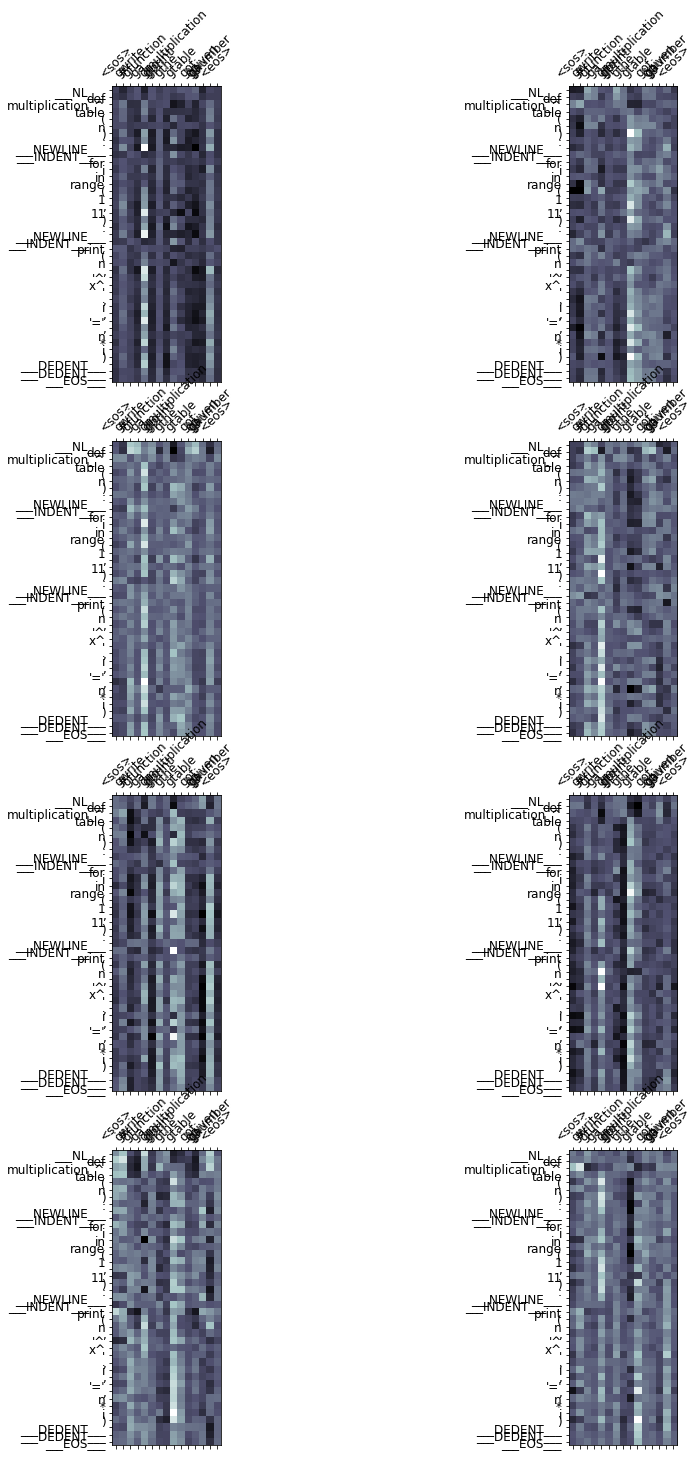

In [46]:
import matplotlib.ticker as ticker

#display_attention(splitted_text, mycode, attention_val[:,2,:,:].unsqueeze(1), n_heads=1, n_rows=1, n_cols=1)
n_heads=8
n_rows=4
n_cols=n_heads/n_rows
display_attention(splitted_text, 
                  mycode, 
                  attention_val[:,:8,:,:], 
                  n_heads=n_heads, 
                  n_rows=n_rows, 
                  n_cols=n_cols)


In [ ]:
nl_to_pl_df = pd.read_csv("/content/end_capstone.csv")
nl_to_pl_df['gen_code'] = "NoCode"
nl_to_pl_df['R1_precision'] = 0.0
nl_to_pl_df['R1_recall'] = 0.0
nl_to_pl_df['R1_f'] = 0.0
nl_to_pl_df['RL_precision'] = 0.0
nl_to_pl_df['RL_recall'] = 0.0
nl_to_pl_df['RL_f'] = 0.0

#### Evaluation with Rouge Metrics

In [51]:
!pip install rouge-score
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeLsum', 'rougeL'], use_stemmer=False)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [ ]:
scorer = rouge_scorer.RougeScorer(['rougeLsum', 'rougeL'], use_stemmer=False)

all_strings = nl_to_pl_df.loc[(nl_to_pl_df['cleaned_code_len'] <= 512), :]

gen_code_arr = []
#for one_string in all_strings[1500:1549].itertuples():
error_count = 0
for idx, one_string in enumerate(all_strings.itertuples()):
    gen_code = "NoCode"
    cleaned_string = one_string.docstring.rstrip('\n').lstrip('#')
    #print(cleaned_string)
    try:
        mycode, my_tok, attention_val = get_code(cleaned_string,
                                        auto_tokenizer, 
                                        init_tokenizer,
                                        code_tok_vectorizer,
                                        model, 
                                        device,
                                        max_len=200)
        gen_code = init_tokenizer.untokenize(mycode)
        scores = scorer.score(gen_code, one_string.cleaned_code)
        #print(scores)
        #one_string.gen_code = gen_code
        #nl_to_pl_df.iloc[one_string.Index, -1] = gen_code
        nl_to_pl_df.iloc[one_string.Index, 6] = gen_code
        nl_to_pl_df.iloc[one_string.Index, 7] = scores['rougeLsum'].precision
        nl_to_pl_df.iloc[one_string.Index, 8] = scores['rougeLsum'].recall
        nl_to_pl_df.iloc[one_string.Index, 9] = scores['rougeLsum'].fmeasure
        nl_to_pl_df.iloc[one_string.Index, 10] = scores['rougeL'].precision
        nl_to_pl_df.iloc[one_string.Index, 11] = scores['rougeL'].recall
        nl_to_pl_df.iloc[one_string.Index, 12] = scores['rougeL'].fmeasure
        #gen_code_arr.append(gen_code)
        #print()
    except:
        error_count += 1
        print(f"Total: {idx} Error Count: {error_count} for: {cleaned_string}")
        #gen_code_arr.append(gen_code)
        continue

Total: 74 Error Count: 1 for:  write a python program to Get the maximum and minimum value in a dictionary
Total: 267 Error Count: 2 for: python program to implement stooge sort
Total: 268 Error Count: 3 for:  Python program to find the  difference between two times
Total: 386 Error Count: 4 for:  write a program to convert time from 12 hour to 24 hour format 
Total: 387 Error Count: 5 for:  write a program to find the difference between two timestamps 
Total: 396 Error Count: 6 for:  write a program to check whether a given string is Heterogram or not  
Total: 399 Error Count: 7 for:  write a program that extract words starting with Vowel From A list
Total: 406 Error Count: 8 for:  write a program to check if a string has at least one letter and one number
Total: 434 Error Count: 9 for:  write a program to add two matrices using nested loop
Total: 436 Error Count: 10 for:  write a program to multiply two matrices using nested loops
Total: 471 Error Count: 11 for:  Write a python progr

In [ ]:
metrics = [ col for col in nl_to_pl_df.columns.values if "R1" in col or "RL" in col ]

In [ ]:
nl_to_pl_df.loc[(nl_to_pl_df['gen_code'] == "NoCode"),:].count()

docstring           244
code                244
docstring_len       244
code_len            244
cleaned_code        244
cleaned_code_len    244
gen_code            244
R1_precision        244
R1_recall           244
R1_f                244
RL_precision        244
RL_recall           244
RL_f                244
dtype: int64

In [ ]:
nl_to_pl_df.loc[(nl_to_pl_df['gen_code'] != "NoCode"), metrics].mean()

R1_precision    0.810637
R1_recall       0.836924
R1_f            0.816128
RL_precision    0.796703
RL_recall       0.820371
RL_f            0.801579
dtype: float64

In [ ]:
nl_to_pl_df.loc[:, metrics].mean()

R1_precision    0.770035
R1_recall       0.794166
R1_f            0.774787
RL_precision    0.753456
RL_recall       0.774927
RL_f            0.757618
dtype: float64